<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/IncomePyTorchTabularModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch TabularModel
* Pull in UCI Income Dataset (Forcast >= 50k Income)
* Use PyTorch & Build a Tabular Model
* Categorical Variables using Embedding
* Adapted from Udemy (Deep Learning - PyTorch) 

# Setup

In [0]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Data
* https://archive.ics.uci.edu/ml/datasets/census+income

In [0]:
df = pd.read_csv('/content/income.csv')

In [3]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


# Model

## Categorical & Continuous
* Grab columns for categorical and continuous values

In [0]:
categorical = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
continuous  = ['age', 'hours-per-week']
label       = ['label']

In [6]:
for col in categorical:
  df[col] = df[col].astype('category')
df.dtypes

age                  int64
sex               category
education         category
education-num        int64
marital-status    category
workclass         category
occupation        category
hours-per-week       int64
income              object
label                int64
dtype: object

## Shuffle Data
* Shuffle up the dataset

In [0]:
df = shuffle(df, random_state=22)
df.reset_index(drop=True, inplace=True)

## Embedding Sizes
* We're going to create an embedding for each categorical variable
* Sizes = min 50 or (size + 1) // 2

In [7]:
cat_sz = [len(df[col].cat.categories) for col in categorical]
emb_sz = [(size, min(50, (size + 1) // 2)) for size in cat_sz]
emb_sz

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

## Tensors

In [88]:
cats = np.stack([df[col].cat.codes.values for col in categorical], axis=1)
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[ 1, 10,  3,  2,  1],
        [ 1, 11,  1,  1,  2],
        [ 1, 10,  0,  3,  7],
        [ 0, 12,  3,  0,  7],
        [ 0,  1,  5,  2,  3]])

In [62]:
cont = np.stack([df[col].values for col in continuous], axis=1)
cont = torch.tensor(cont, dtype=torch.float)
cont[0:5]

tensor([[27., 40.],
        [47., 50.],
        [59., 20.],
        [38., 57.],
        [64., 40.]])

In [89]:
y = torch.tensor(df[label].values).flatten() #.reshape(-1,1)
y

tensor([0, 1, 0,  ..., 1, 0, 1])

## Train - Test

In [0]:
batch = 30000
test  = 5000

cat_train = cats[: batch - test]
cat_test  = cats[batch - test : batch]

cont_train = cont[: batch - test]
cont_test  = cont[batch - test : batch]

y_train = y[: batch - test]
y_test  = y[batch - test : batch]

## Model
* Define the Torch Neural Net
* Embeddings for each categorical
  * Sizes passed as parameter
  * Apply dropout
  * Batch norm later
* Continous concatencated to embeddings
  * Passed through Batch Norm
* Fully connected through Layers parameter list
* Output size 2 (binary classification)

In [0]:
class Tabular(nn.Module):
  def __init__(self, emb_szs, n_cont, out_sz, layers, dropout=0.5):
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
    self.emb_drop = nn.Dropout(dropout)
    self.bn_cont = nn.BatchNorm1d(n_cont)

    layerList = []

    n_emb = sum((nf for ni, nf in emb_szs))
    n_in  = n_emb + n_cont

    for i in layers:
      layerList.append(nn.Linear(n_in, i))
      layerList.append(nn.ReLU(inplace=True))
      layerList.append(nn.BatchNorm1d(i))
      layerList.append(nn.Dropout(dropout))
    
    layerList.append(nn.Linear(layers[-1], out_sz))
    self.layers = nn.Sequential(*layerList)

  def forward(self, x_cat, x_cont):
    embeddings = []
    for i, e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:, i]))
    x = torch.cat(embeddings, axis=1)
    x = self.emb_drop(x)
    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x, x_cont], axis=1)
    x = self.layers(x)
    return x

In [0]:
model = Tabular(emb_szs = emb_sz, 
                n_cont  = 2, 
                out_sz  = 2, 
                layers  = [50], 
                dropout = 0.4)

In [73]:
model

Tabular(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

## Criterion & Optimizer
* Cross Entropy Loss -(p * log(y) + (1-p) * log(1-y))
* Adam optimizer with learning rate 0.001

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001)

## Fit
* Run 300 epochs

In [78]:
start_time = time.time()

epochs = 300
losses = []

for epoch in range(epochs):
  epoch += 1

  # Forward Pass, Compute Loss
  y_pred = model(cat_train, cont_train)
  loss = criterion(y_pred, y_train)
  losses.append(loss)
    
  if epoch % 25 == 1:
    print(f'epoch: {epoch:3}  loss: {loss.item():10.8f}')
    
  # Zero Gradients, BackProp
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(f'epoch: {epoch:3}  loss: {loss.item():10.8f}') 
print(f'\\nDuration: {time.time() - start_time:.0f} seconds') 

epoch:   1  loss: 0.76812375
epoch:  26  loss: 0.53190112
epoch:  51  loss: 0.46186328
epoch:  76  loss: 0.42501107
epoch: 101  loss: 0.40205878
epoch: 126  loss: 0.38155901
epoch: 151  loss: 0.36454487
epoch: 176  loss: 0.35160059
epoch: 201  loss: 0.33593804
epoch: 226  loss: 0.33037892
epoch: 251  loss: 0.32334593
epoch: 276  loss: 0.31666604
epoch: 300  loss: 0.31065208
\nDuration: 100 seconds


## Plot Results

Text(0.5, 0, 'Epochs')

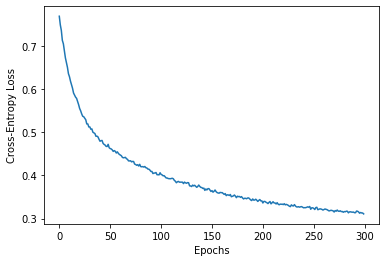

In [79]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross-Entropy Loss')
plt.xlabel('Epochs')

# Evaluate

In [80]:
with torch.no_grad():
  y_val = model(cat_test, cont_test)
  loss = criterion(y_val, y_test)
print(f'Cross Entropy Loss {loss:.8f}')

Cross Entropy Loss 0.31213114


In [87]:
correct = 0
rows    = len(y_test)
for index in range(rows):
  if y_val[index].argmax().item() == y_test[index]:
    correct += 1
print(f'{correct} out of {rows} = {100 * correct / rows}% Correct')

4286 out of 5000 = 85.72% Correct
